<font size="5"> CS6364/CS4364: Assignment 2</font><br>
<font size="5"> Part: 2 </font><br>
<font size="5"> EmotionLines: Dialogue Emotion Dataset </font><br>
<font size="4"> Sagar Sheth </font>

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
import nltk
import json
from nltk import pos_tag
import string
from collections import Counter

In [196]:
file_path = 'friends_train.json'

with open(file_path, 'r') as file:
    data = json.load(file)

flat_data = [utterance for conversation in data for utterance in conversation]


df = pd.DataFrame(flat_data)
df

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030
...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011
10558,Joey,"You guys are messing with me, right?",surprise,0000050
10559,All,Yeah.,neutral,4000010


In [197]:
df.isnull().sum()

speaker       0
utterance     0
emotion       0
annotation    0
dtype: int64

### Performing Tokenization and Lemmatization along with removal of stop words

In [198]:

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    
    return [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in string.punctuation] if not filtered_words else filtered_words

df['tokenize_text'] = df['utterance'].apply(tokenize_text)

print(df[['utterance', 'tokenize_text']])


                                               utterance  \
0      also I was the point person on my companys tr...   
1                       You mustve had your hands full.   
2                                That I did. That I did.   
3          So lets talk a little bit about your duties.   
4                                 My duties?  All right.   
...                                                  ...   
10556                                         You or me?   
10557  I got it. Uh, Joey, women don't have Adam's ap...   
10558               You guys are messing with me, right?   
10559                                              Yeah.   
10560  That was a good one. For a second there, I was...   

                                   tokenize_text  
0      [also, point, person, transition, system]  
1                                   [hand, full]  
2                   [that, i, did, that, i, did]  
3                      [talk, little, bit, duty]  
4                       

In [199]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalnum()]
    words = [word.lower() for word in words if word.lower() not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


df['processed_text'] = df['utterance'].apply(process_text)

print(df[['utterance', 'processed_text']])

                                               utterance  \
0      also I was the point person on my companys tr...   
1                       You mustve had your hands full.   
2                                That I did. That I did.   
3          So lets talk a little bit about your duties.   
4                                 My duties?  All right.   
...                                                  ...   
10556                                         You or me?   
10557  I got it. Uh, Joey, women don't have Adam's ap...   
10558               You guys are messing with me, right?   
10559                                              Yeah.   
10560  That was a good one. For a second there, I was...   

                            processed_text  
0      also point person transition system  
1                                hand full  
2                                           
3                     talk little bit duty  
4                               duty right  
...      

### Distribution of Emotion

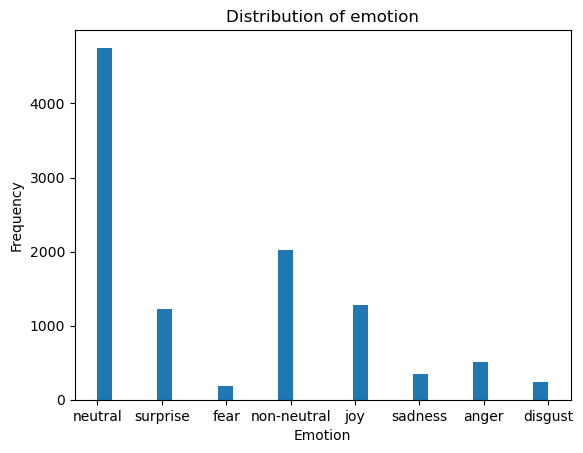

In [200]:
plt.hist(df['emotion'], bins=30)
plt.title('Distribution of emotion')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

### Plotting the Top 20 most frequent words

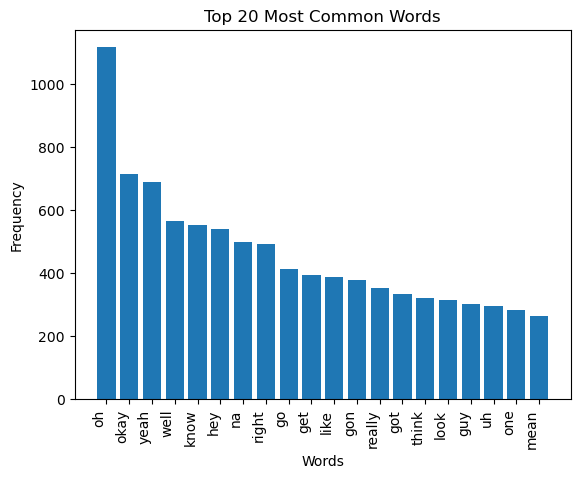

In [201]:
all_processed_words = [word for words_list in df['tokenize_text'] for word in words_list]

word_frequencies = Counter(all_processed_words)

top_n = 20 
top_words, top_frequencies = zip(*word_frequencies.most_common(top_n))

plt.bar(top_words, top_frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Words')
plt.xticks(rotation=90, ha='right')
plt.show()

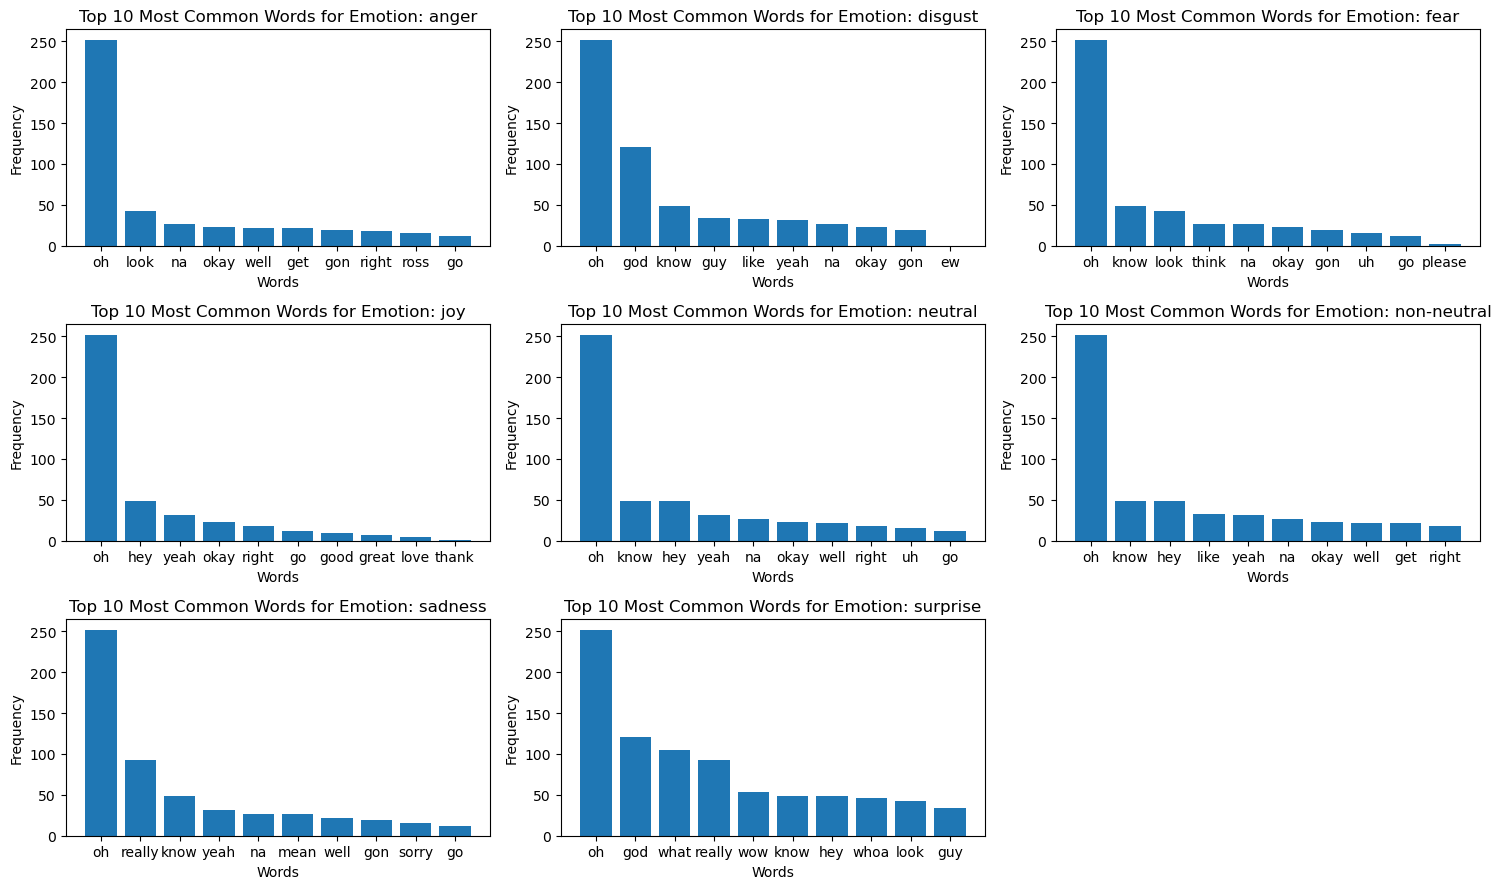

In [202]:
top_words_by_emotion = {}
grouped_df = df.groupby('emotion')
for emotion, group in grouped_df:
    all_processed_words = [word for words_list in group['tokenize_text'] for word in words_list]
    word_frequencies = Counter(all_processed_words)
    top_n = 10
    top_words = [word for word, _ in word_frequencies.most_common(top_n)]

    top_words_by_emotion[emotion] = top_words

num_rows = (len(top_words_by_emotion) + 2) // 3
plots_per_row = 3

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 3 * num_rows))
fig.tight_layout(pad=3.0)

axes = axes.flatten()

for i, (emotion, top_words) in enumerate(top_words_by_emotion.items()):
    ax = axes[i]
    sorted_word_frequencies = sorted(
        ((word, word_frequencies[word]) for word in top_words),
        key=lambda x: x[1],
        reverse=True
    )
    
    sorted_words, sorted_frequencies = zip(*sorted_word_frequencies)
    ax.bar(sorted_words, sorted_frequencies)
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Top {top_n} Most Common Words for Emotion: {emotion}')

for i in range(len(top_words_by_emotion), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Applying TFID to convert String to Number

In [203]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])
df_tf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

df = df.reset_index(drop=True)
df_tf = df_tf.reset_index(drop=True)

df2 = pd.concat([df, df_tf], axis=1)

### Creating Target Variable from Emotion

In [204]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df2['emotion_numerical'] = label_encoder.fit_transform(df['emotion'])

print(df2[['emotion', 'emotion_numerical']])

print("Mapping of Original Emotion Values to Numerical Values:")
for original_value, numerical_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_value}: {numerical_value}")


           emotion  emotion_numerical
0          neutral                  4
1          neutral                  4
2          neutral                  4
3          neutral                  4
4         surprise                  7
...            ...                ...
10556      neutral                  4
10557  non-neutral                  5
10558     surprise                  7
10559      neutral                  4
10560  non-neutral                  5

[10561 rows x 2 columns]
Mapping of Original Emotion Values to Numerical Values:
anger: 0
disgust: 1
fear: 2
joy: 3
neutral: 4
non-neutral: 5
sadness: 6
surprise: 7


In [205]:
y_train=df2['emotion_numerical'].values
x_train=df2.drop(['emotion','speaker','utterance','annotation','processed_text','tokenize_text'],axis=1).values


In [206]:
y_train.shape

(10561,)

In [207]:
x_train.shape

(10561, 4687)

In [208]:
clf_ovr = OneVsRestClassifier(SVC())

# Train the classifier
clf_ovr.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [209]:
y_pred_ovr = clf_ovr.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred_ovr))

Accuracy: 1.0


In [178]:
print("Classification Report:")
print(classification_report(y_train, y_pred_ovr))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       513
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       185
           3       1.00      1.00      1.00      1283
           4       1.00      1.00      1.00      4752
           5       1.00      1.00      1.00      2017
           6       1.00      1.00      1.00       351
           7       1.00      1.00      1.00      1220

    accuracy                           1.00     10561
   macro avg       1.00      1.00      1.00     10561
weighted avg       1.00      1.00      1.00     10561



In [224]:
from sklearn.svm import LinearSVC
model = LinearSVC()

# train the model
model.fit(x_train, y_train)

C:\Users\sagar\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sagar\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [225]:
y_pred_ovr2 = model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred_ovr2))

Accuracy: 0.8457532430641038


In [226]:
print("Classification Report:")
print(classification_report(y_train, y_pred_ovr2))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       513
           1       0.99      0.82      0.90       240
           2       0.96      0.43      0.60       185
           3       0.85      0.66      0.75      1283
           4       0.78      0.95      0.86      4752
           5       0.89      0.64      0.74      2017
           6       0.90      0.77      0.83       351
           7       1.00      1.00      1.00      1220

    accuracy                           0.85     10561
   macro avg       0.92      0.78      0.83     10561
weighted avg       0.86      0.85      0.84     10561



### Importing Test and Holdout dataset

In [211]:
file_path = 'friends_test.json'

with open(file_path, 'r') as file:
    data = json.load(file)

flat_data = [utterance for conversation in data for utterance in conversation]


df_test = pd.DataFrame(flat_data)
df_test

,speaker,utterance,emotion,annotation
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011
2,Rachel,Y'know what?,neutral,3000020
3,Ross,It didnt.,neutral,5000000
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010
...,...,...,...,...
2759,Phoebe,"Hey, why dont you guys go get portraits done ...",neutral,5000000
2760,Monica,Thats a good idea! I bet they have one of tho...,joy,1400000
2761,Phoebe,"Yeah thats great! Next to that, Chandler won...",neutral,3100100
2762,Monica,Chandler what do you say?,neutral,5000000


In [212]:
df_test.isnull().sum()

speaker       0
utterance     0
emotion       0
annotation    0
dtype: int64

In [213]:
df_test['processed_text'] = df_test['utterance'].apply(process_text)

print(df_test[['utterance', 'processed_text']])

                                              utterance  \
0     Why do all youre coffee mugs have numbers on ...   
1     Oh. Thats so Monica can keep track. That way ...   
2                                          Y'know what?   
3                                            It didnt.   
4     Okay, so what you used to have with Rachel, is...   
...                                                 ...   
2759  Hey, why dont you guys go get portraits done ...   
2760  Thats a good idea! I bet they have one of tho...   
2761  Yeah thats great! Next to that, Chandler won...   
2762                          Chandler what do you say?   
2763  All right, but I should warn you, Im not goin...   

                                         processed_text  
0                              coffee mug number bottom  
1     oh monica keep track way one missing like numb...  
2                                                        
3                                                        
4

In [215]:
df_test['emotion_numerical'] = df_test['emotion'].map({'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'non-neutral':5,
       'sadness':6, 'surprise':7})

In [216]:
tfidf_matrix_test = tfidf_vectorizer.fit_transform(df_test['processed_text'])
df_tf_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_test2 = pd.concat([df_test.reset_index(drop=True), df_tf.reset_index(drop=True)], axis=1)

In [217]:
df_test2

,speaker,utterance,emotion,annotation,processed_text,emotion_numerical,10,100,110,112,...,zelda,zelner,zero,zillionaire,zinfandel,zip,zone,zoo,zuchoff,zygomatic
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030,coffee mug number bottom,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011,oh monica keep track way one missing like numb...,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Rachel,Y'know what?,neutral,3000020,,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ross,It didnt.,neutral,5000000,,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010,okay used rachel got alice,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10556,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10557,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10558,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10559,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
df_test2.isnull().sum()

speaker           7797
utterance         7797
emotion           7797
annotation        7797
processed_text    7797
                  ... 
zip                  0
zone                 0
zoo                  0
zuchoff              0
zygomatic            0
Length: 4693, dtype: int64

In [219]:
df_test3=df_test2.dropna()
df_test3.isnull().sum()

speaker           0
utterance         0
emotion           0
annotation        0
processed_text    0
                 ..
zip               0
zone              0
zoo               0
zuchoff           0
zygomatic         0
Length: 4693, dtype: int64

In [220]:
y_test=df_test3['emotion_numerical'].values
x_test=df_test3.drop(['emotion','speaker','utterance','annotation','processed_text'],axis=1).values

In [221]:
y_pred_ovr_test = clf_ovr.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_ovr_test))

Accuracy: 0.05824891461649783


In [222]:
print("Classification Report:")
print(classification_report(y_test, y_pred_ovr_test))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.06      1.00      0.11       161
         1.0       0.00      0.00      0.00        68
         2.0       0.00      0.00      0.00        32
         3.0       0.00      0.00      0.00       304
         4.0       0.00      0.00      0.00      1287
         5.0       0.00      0.00      0.00       541
         6.0       0.00      0.00      0.00        85
         7.0       0.00      0.00      0.00       286

    accuracy                           0.06      2764
   macro avg       0.01      0.12      0.01      2764
weighted avg       0.00      0.06      0.01      2764



C:\Users\sagar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [227]:
y_pred_ovr_test2 = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_ovr_test2))

Accuracy: 0.055716353111432707
